### <b>Table of Content</b>

0. Import functions

1. Load data

2. Exploratory data analysis (EDA)

3.

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [1]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, seasonal_decomposition, normalize_scale
from utils.plot import plot_histograms, plot_heatmap, plot_autocorrelation
from utils.predict import get_trading_decision_and_results
from utils.evaluate import get_capital_returns, get_capital_return_df

import warnings
warnings.simplefilter('ignore', UserWarning)

### <b>1. Load data</b>

In [2]:
# Assign details of the source file in G Drive to local variables.
base_url = 'https://drive.google.com/file/d/'
file_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
file_url = f'{base_url}{file_id}'
file_name = '2020Q1Q2Q3Q4-2021Q1.xlsx'

# Assign details of local directories to local variables.
root_dir = sys.path[0]
download_dir = Path(root_dir) / 'data'
file_path = download_dir / file_name

# Download the file if it's not found in the file path.
if os.path.exists(file_path):
    print(f'File {file_name} already exists in {download_dir}.')
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f'File {file_name} is not found in {download_dir}.')
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

# Move back to the root directory.
if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in d:\OneDrive\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [3]:
full_sheet_names = [
    'Russia - Sberbank Rossii PAO (SBER)',
    'Turkey - Koc Holding AS (KCHOL)',
    'Egypt - Medinet Nasr Housing (MNHD)',
    'Brazil - Minerva SA/Brazil (BEEF3)',
    'Argentina - Pampa Energia SA (PAMP)',
    'Colombia - Cementos Argos SA (CCB)',
    'South Africa - Impala Platinum Holdings Ltd (IMPJ)',
    'South Korea - Dongkuk Steel Mill Co Ltd (001230)'
]
data_dfs = load_dataframes(file_path, full_sheet_names)

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


### <b>2. Exploratory data analysis (EDA)</b>

#### 2-1. Examine the format and perform basic data manipulation

We have loaded 8 DataFrames (for 8 different stocks) but the format of each of the DataFrames should be the same.<br>
Have a look at the first one.

In [4]:
first_df = data_dfs[full_sheet_names[0]]
print('Basic info of the first DateFrame:\n')
print(first_df.info())
print('\n')
print('Tail of the first DataFrame:\n')
print(first_df.tail())

Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Tail of the first DataFrame:

          Date   Price    Open    High     Low    Vol.  Change %
306 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
307 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
308 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
309 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
310 2020-01-

- Since we have time-series data, set the 'Date' column as index.
- The dtype of the 'Vol.' column is object, which needs to be converted to either integer or float so that the values are machine-readable, in other words so that they can be used as a training feature.
- Additionally, the 'Price' column will be the target to be predicted, which is the closing price for each trading date.

In [5]:
df = first_df.set_index('Date').sort_index()
df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071


#### 2-2. Plot histograms and box plots to understand the distribution of each column

Distribution of target 'Price' and dependent variables:


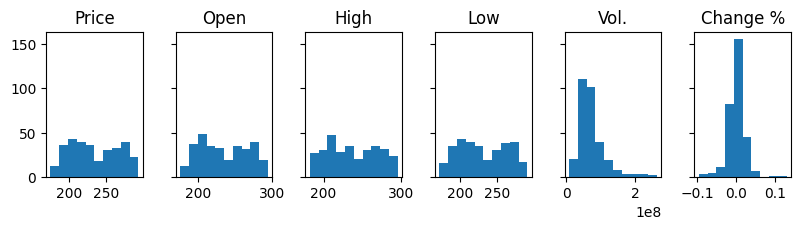

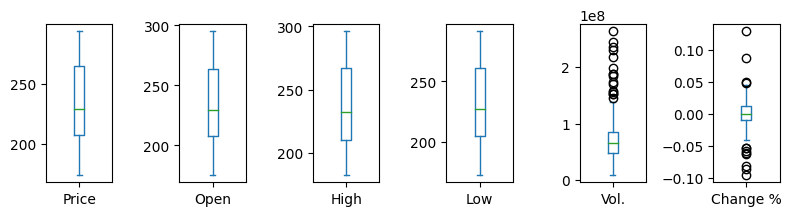

In [6]:
plot_histograms(data=df,
                target='Price', target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

- The 'Vol.' column is right-skewed.
- The 'Change %' column is roughly normally distributed.
- The 'Vol.' and 'Change %' columns have many outliers. 
- The other columns show bimodal distributions without outliers.

#### 2-3. Plot a correlation heatmap and analyze correlations between the target and other columns

,Price,Open,High,Low,Vol.,Change %
Price,1.000000,0.992246,0.996541,0.995765,-0.245279,0.089939
Open,0.992246,1.000000,0.996392,0.996370,-0.262197,-0.014046
High,0.996541,0.996392,1.000000,0.994497,-0.215092,0.034574
Low,0.995765,0.996370,0.994497,1.000000,-0.291138,0.037396
Vol.,-0.245279,-0.262197,-0.215092,-0.291138,1.000000,0.044594
Change %,0.089939,-0.014046,0.034574,0.037396,0.044594,1.000000


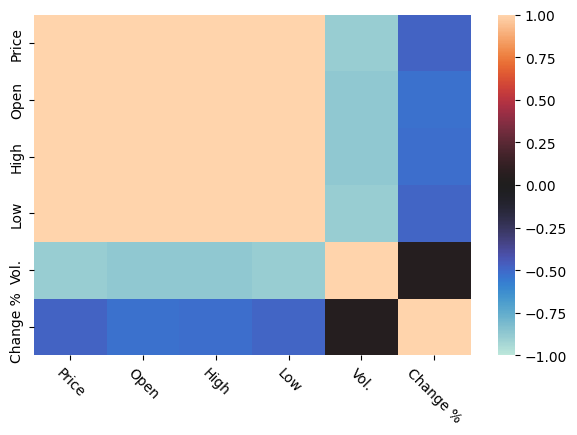

In [7]:
plot_heatmap(df.corr(), figsize=(6, 4), rotate_xticks=-45)
df.corr()

- The correlation between the 'Change %' and the target (i.e. 'Price') column is very low - less than 0.1.
- The correlation between the 'Vol.' and 'Price' columns is also pretty low - the absolute value of it is less than 0.3.
- Thus, these two columns would not be useful in training a predictive model.

#### 2-4. Perform STL (Seasonal and Trend decomposition using LOESS) to identify seasonalities in the data

STL is a versatile and robust method for decomposing time series.<br>
LOESS (Locally Estimated Scatterplot Smoothing) is a nonparametric method, where no assumptions are made about the underlying structure of a series of data, for estimating nonlinear relationships. It uses local regression to fit a smooth curve through a scatterplot of data.

Although STL can capture general patterns without assuming data, it does not automatically handle trading day or calendar variation, and it only provides facilities for additive decompositions.

Plotting seasonal componets:


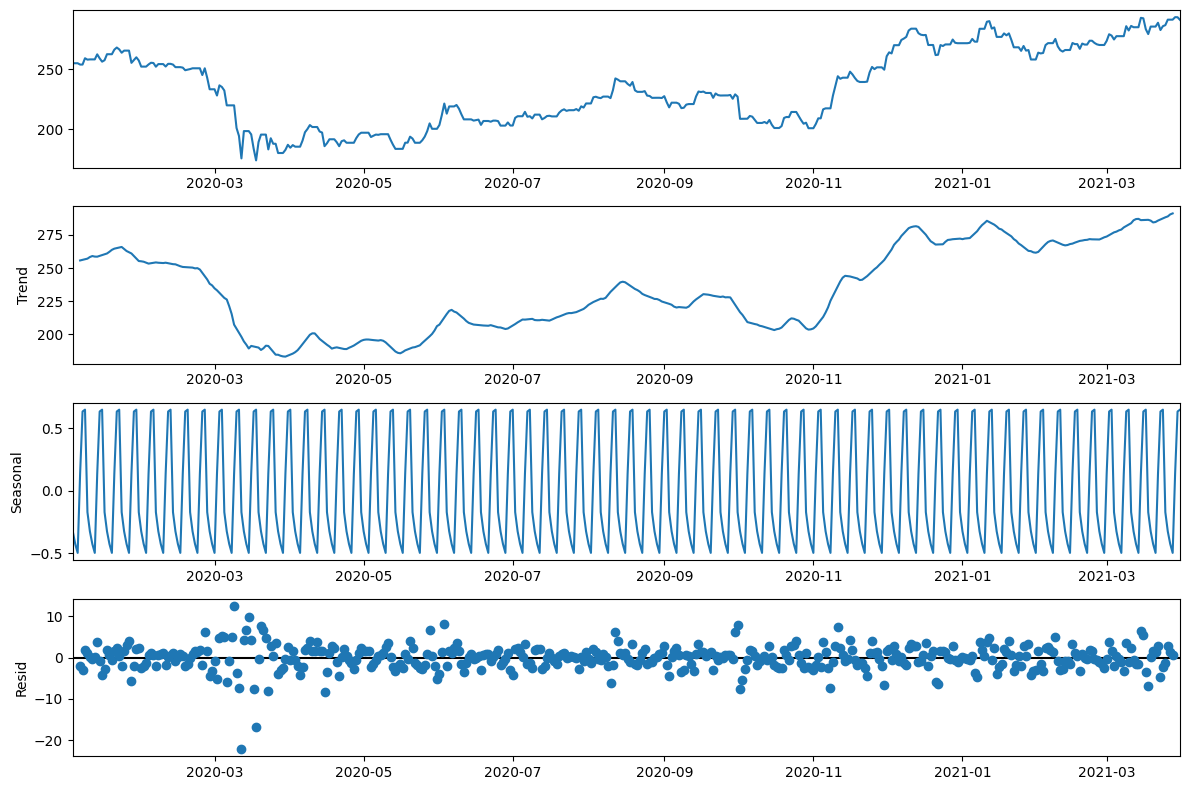

In [8]:
seasonal_decomposition(df=df, frequency='D', column='Price', add_to_df=False, plot=True)

- The original data and the Trend component (i.e. the first and second plots) look very similar, indicating seasonality in the time series data is not significant.
- The patterns observed from the Seasonal plot are likely due to the regularity of the trading dates - i.e. No trading data during weekends and almost the same seasonal pattern is observed on a weekly basis.
- Most of the residuals (i.e. the Resid plot) are centered around 0 with not a lot of data points whose absolute values are greater than 10.

#### 2-5. Plot auto correlation and partial autocorrelation

The ACF (Auto-Correlation Function) returns autocorrelations over time where variability can be explained by multiple points in time.<br>
Whereas, the PACF (Partial ACF) returns partial autocorrelation for each point in time, in other words only the additional autocorrelation between the current and previous points in time.

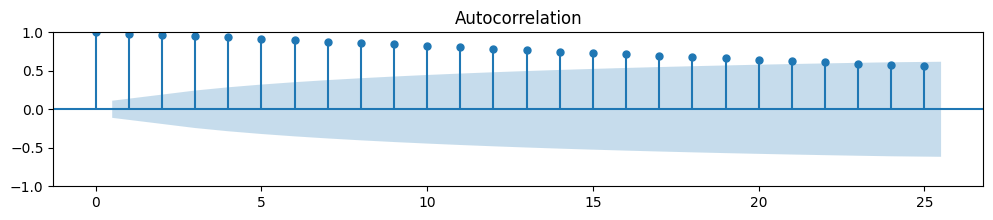

In [9]:
plot_autocorrelation(df, 'Price', partial=False)

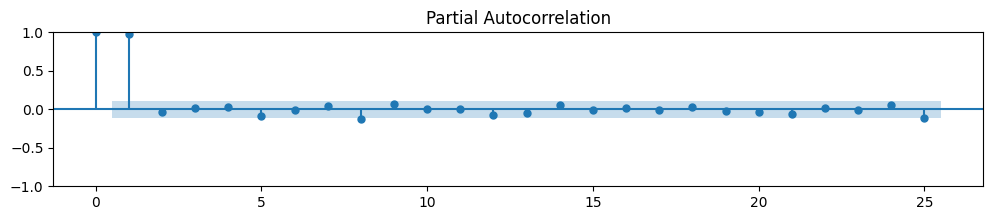

In [10]:
plot_autocorrelation(df, 'Price', partial=True)

The next day (i.e. where the X value in the plot is 1) has an autocorrelation of almost 1, meaning only the previous day would be relevant to today. To put it differently, most past data except for yesterday's data may not be helpful in predicting today's data, in our case today's closing price (i.e. the 'Price' column).

The blue area in the ACF and PACF plots below depicts the 95% confidence interval, meaning anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

### <b>3. feature selection and engineering</b>

possible features to use:
- on average has the price gone up or donw in the last week?
- what is the change over the last 2 days (prices on day-1 vs. day-2), last 3 days, 4 days, or a week?
- this is to get model learns/captures the price movement in the recent past.


* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.

1. 'Vol.' and 'Change %' are not relevant based on correlation coefficeints with the target column 'Price', hence drop them.
2. Only the previous date's price is highly correlated with today's price based on auto correlation, thus don't look too further in the past.

In [38]:
import pandas as pd

def add_features_from_previous_dates(df, previous_date_range=[2, 3, 4, 5, 6, 7]):
    df['Trend'] = df['Change %'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df = df.drop(['Vol.', 'Change %'], axis=1)
    # df = df.drop(['Change %'], axis=1)

    price_previous_day = df[:-1]
    price_previous_day.index = df.index[1:]
    price_previous_day = price_previous_day.rename(columns={col: f'{col} (Day-1)' for col in df.columns})

    price_sma_dfs = []
    price_ema_dfs = []
    max_high_dfs = []
    min_low_dfs = []
    max_min_diff_dfs = []
    diff_dfs = []
    trend_dfs = []
    vol_sma_dfs = []
    vol_ema_dfs = []
    max_vol_dfs = []
    min_vol_dfs = []
    for num_day in previous_date_range:
        index = df.index[num_day : ]

        price_sma_df = df['Price'].rolling(window=num_day).mean()[ (num_day-1) : -1]
        price_sma_df.index = index
        price_sma_df.name = f'{num_day} Day SMA Price (Day-1)'
        price_sma_dfs.append(price_sma_df)

        price_ema_df = df['Price'].ewm(span=num_day).mean()[ (num_day-1) : -1]
        price_ema_df.index = index
        price_ema_df.name = f'{num_day} Day EMA Price (Day-1)'
        price_ema_dfs.append(price_ema_df)

        max_high_df = df['High'].rolling(window=num_day).max()[ (num_day-1) : -1]
        max_high_df.index = index
        max_high_df.name = f'{num_day} Day Max High (Day-1)'
        max_high_dfs.append(max_high_df)

        min_low_df = df['Low'].rolling(window=num_day).min()[ (num_day-1) : -1]
        min_low_df.index = index
        min_low_df.name = f'{num_day} Day Min Low (Day-1)'
        min_low_dfs.append(min_low_df)

        max_min_diff_df = max_high_df - min_low_df
        max_min_diff_df.name = f'{num_day} Day MaxHigh-MinLow Difference (Day-1)'
        max_min_diff_dfs.append(max_min_diff_df)

        diff_df = df['Price'].diff(periods=num_day)[ (num_day-1) : -1]
        diff_df.index = index
        diff_df.name = f'{num_day} Day Price Difference (Day-1)'
        diff_dfs.append(diff_df)

        trend_df = df['Trend'].rolling(window=num_day).sum()[ (num_day-1) : -1]
        trend_df.index = index
        trend_df.name = f'{num_day} Day Trend (Day-1)'
        trend_dfs.append(trend_df)

        # Add Vol. features
        # vol_sma_df = df['Vol.'].rolling(window=num_day).mean()[ (num_day-1) : -1]
        # vol_sma_df.index = index
        # vol_sma_df.name = f'{num_day} Day SMA Vol. (Day-1)'
        # vol_sma_dfs.append(vol_sma_df)

        # vol_ema_df = df['Vol.'].ewm(span=num_day).mean()[ (num_day-1) : -1]
        # vol_ema_df.index = index
        # vol_ema_df.name = f'{num_day} Day EMA Vol. (Day-1)'
        # vol_ema_dfs.append(vol_ema_df)

        # max_vol_df = df['Vol.'].rolling(window=num_day).max()[ (num_day-1) : -1]
        # max_vol_df.index = index
        # max_vol_df.name = f'{num_day} Day Max Vol. (Day-1)'
        # max_vol_dfs.append(max_vol_df)

        # min_vol_df = df['Vol.'].rolling(window=num_day).min()[ (num_day-1) : -1]
        # min_vol_df.index = index
        # min_vol_df.name = f'{num_day} Day Min Vol. (Day-1)'
        # min_vol_dfs.append(min_vol_df)

    df = df.drop(['Trend', 'Open', 'High', 'Low'], axis=1)

    concat_df = pd.concat(
        [df, price_previous_day]
        + price_sma_dfs
        + price_ema_dfs
        + max_high_dfs
        + min_low_dfs
        + max_min_diff_dfs
        + diff_dfs
        + trend_dfs
        + vol_sma_dfs
        + vol_ema_dfs
        + max_vol_dfs
        + min_vol_dfs
        ,
        axis=1).dropna()

    return concat_df

In [39]:
concat_df = add_features_from_previous_dates(df)

# Drop the target column and the columns that will not be available when making predictions
X = concat_df.drop(['Price'], axis=1)
print("Training features:")
print(*list(X.columns), sep='\n')

y = concat_df['Price']
print("\nTarget: Price")

Training features:
Price (Day-1)
Open (Day-1)
High (Day-1)
Low (Day-1)
Trend (Day-1)
2 Day SMA Price (Day-1)
3 Day SMA Price (Day-1)
4 Day SMA Price (Day-1)
5 Day SMA Price (Day-1)
6 Day SMA Price (Day-1)
7 Day SMA Price (Day-1)
2 Day EMA Price (Day-1)
3 Day EMA Price (Day-1)
4 Day EMA Price (Day-1)
5 Day EMA Price (Day-1)
6 Day EMA Price (Day-1)
7 Day EMA Price (Day-1)
2 Day Max High (Day-1)
3 Day Max High (Day-1)
4 Day Max High (Day-1)
5 Day Max High (Day-1)
6 Day Max High (Day-1)
7 Day Max High (Day-1)
2 Day Min Low (Day-1)
3 Day Min Low (Day-1)
4 Day Min Low (Day-1)
5 Day Min Low (Day-1)
6 Day Min Low (Day-1)
7 Day Min Low (Day-1)
2 Day MaxHigh-MinLow Difference (Day-1)
3 Day MaxHigh-MinLow Difference (Day-1)
4 Day MaxHigh-MinLow Difference (Day-1)
5 Day MaxHigh-MinLow Difference (Day-1)
6 Day MaxHigh-MinLow Difference (Day-1)
7 Day MaxHigh-MinLow Difference (Day-1)
2 Day Price Difference (Day-1)
3 Day Price Difference (Day-1)
4 Day Price Difference (Day-1)
5 Day Price Difference (

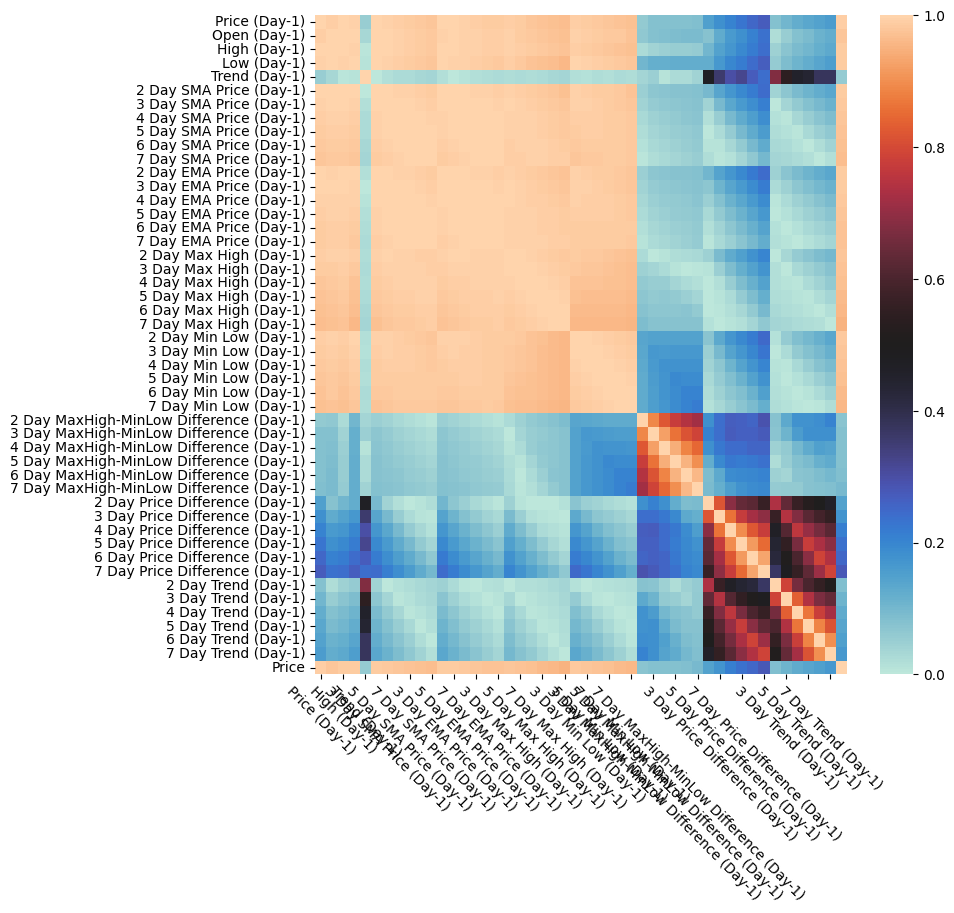

In [40]:
import pandas as pd
corr_df = pd.concat([X, y], axis=1).corr()
for col in corr_df.columns:
    corr_df[col] = corr_df[col].apply(lambda x: abs(x))
plot_heatmap(corr_df, figsize=(10, 10), rotate_xticks=-45, corr_df=True,
             vmin=0, vmax=1, center=0.5)

### <b>4. train models</b>

4-1. train-test split

In [41]:
X_train = X[X.index.year == 2020]
X_test = X[X.index.year == 2021]

y_train = y[y.index.year == 2020]
y_test = y[y.index.year == 2021]

In [42]:
# X_train, X_test, scaler = normalize_scale(X_train, X_test, method="standard")

In [43]:
# RNN time series

# https://www.section.io/engineering-education/univariate-time-series-using-recurrent-neural-networks/

# https://medium.com/@marianne.benkamoun/stock-price-prediction-using-recurrent-neural-networks-369c21817da8

# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [44]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

tf.random.set_seed(5)

timesteps = 1
num_features = X.shape[1]
num_outputs = 1
num_epochs = 10 # 10 ~ 100?
batch_size = 1 # 1 ~ 20?

# Define the model architecture
model = Sequential()
model.add(tf.keras.layers.Reshape((timesteps, num_features), input_shape=(num_features,)))
# model.add(LSTM(64, input_shape=(timesteps, num_features)))  # Adjust the number of LSTM units as needed
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, num_features)))  # Adjust the number of LSTM units as needed
model.add(Dropout(0.5))

model.add(tf.keras.layers.Reshape((timesteps, 64), input_shape=(64,)))
model.add(LSTM(64, input_shape=(timesteps, num_features)))  # Adjust the number of LSTM units as needed
model.add(Dropout(0.5))

model.add(Dense(num_outputs))  # Adjust the number of output units as needed

# Compile the model
model.compile(optimizer='adam', loss='mape')  # Adjust the optimizer and loss function as needed
# MAPE (mean absolute percentage error): a loss function that takes into account the relative magnitude of the predictions.
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)  # Adjust the training data and parameters as needed

# Evaluate the model
loss = model.evaluate(X_test, y_test)  # Adjust the test data as needed

# Make predictions
predictions = model.predict(X_test)  # Adjust the test data as needed

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_13 (Reshape)        (None, 1, 47)             0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 64)             28672     
                                                                 
 dropout_7 (Dropout)         (None, 1, 64)             0         
                                                                 
 reshape_14 (Reshape)        (None, 1, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [45]:
predictions

array([[102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.19694 ],
       [102.19694 ],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.196945],
       [102.1

4-2. Perform stepwise search to find the best order with the smallest AIC

In [46]:
# https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                    exogenous= X_train,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
step_wise.summary()

# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1459.458, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1456.681, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1458.224, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1458.175, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1454.715, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.369 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  242
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -726.358
Date:                Tue, 18 Jul 2023   AIC                           1454.715
Time:                        17:19:08   BIC                           1458.200
Sample:                             0   HQIC                          1456.119
                                - 242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.2881      1.324     18.350      0.000      21.694      26.882
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               132.37
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

4-3. Train a SARIMAX model using the best orders found from the stepwise search above

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  242
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1229.245
Date:                Tue, 18 Jul 2023   AIC                           2554.490
Time:                        17:19:10   BIC                           2721.761
Sample:                             0   HQIC                          2621.881
                                - 242                                         
Covariance Type:                  opg                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Price (Day-1)                             2.77e+12   3.07e+06   9.02e+05      0.000    2.77e+12    2.77e+12
Open (Day-1)                               -

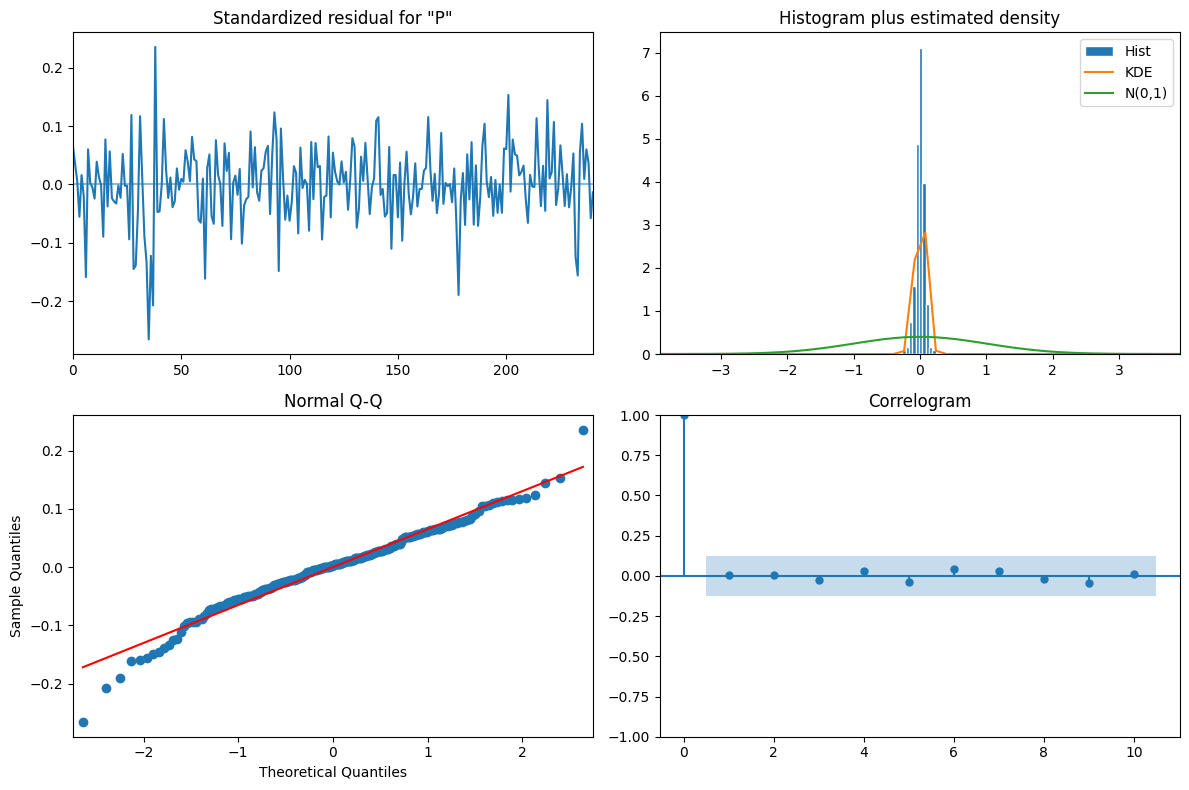

In [47]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

sarimax_model = SARIMAX(
    endog = y_train,
    exog = X_train,
    order=step_wise.order, # (0, 1, 0)
    seasonal_order=step_wise.seasonal_order # (0, 0, 0, 0)
    )
results = sarimax_model.fit(disp=False)
print(results.summary())

results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method above produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
3. Normal Q-Q plot, with Normal reference line.
4. Correlogram

train a random forest regressor and xgb regressor and compare performance of different models
=> SARIMAX seems to perform the best.

In [48]:
from sklearn.metrics import mean_squared_error, r2_score
pred = results.get_prediction(start=X_train.shape[0],
                              end=X_train.shape[0] + X_test.shape[0] - 1,
                              exog=X_test)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean
pred_mean.index = X_test.index
print(f'''SARIMAX model:
Mean Squared Error: {mean_squared_error(y_test, pred_mean)}
R2 Score: {r2_score(y_test, pred_mean)}
''')

# Train non-timeseries regression models
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
rf_reg = RandomForestRegressor(max_depth=2, random_state=5)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)
rf_pred = pd.Series(rf_pred, index=X_test.index)
print(f'''RandomForestRegressor:
Mean Squared Error: {mean_squared_error(y_test, rf_pred)}
R2 Score: {r2_score(y_test, rf_pred)}
''')

from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=5)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
xgb_pred = pd.Series(xgb_pred, index=X_test.index)
print(f'''XGBRegressor:
Mean Squared Error: {mean_squared_error(y_test, xgb_pred)}
R2 Score: {r2_score(y_test, xgb_pred)}
''')

SARIMAX model:
Mean Squared Error: 145.63643668363554
R2 Score: -0.7605929811158447

RandomForestRegressor:
Mean Squared Error: 158.12680207947878
R2 Score: -0.9115885022110461

XGBRegressor:
Mean Squared Error: 85.15318581529174
R2 Score: -0.029413412467140798



#### 5. Create Bollinger Bands and compare it with the SARIMAX predictions to make trading decisions.

* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.

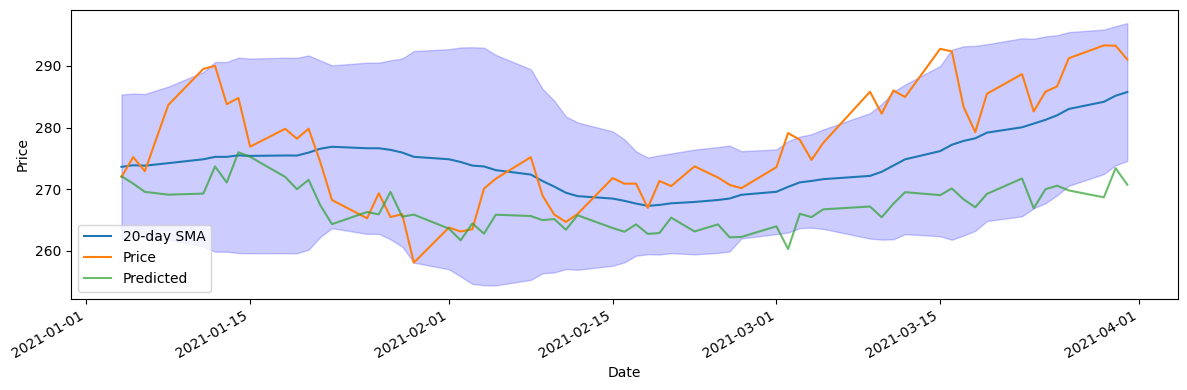

In [49]:
bollinger_band_window = 20
bollinger_band_std = 2

rolling_mean = y.rolling(window=bollinger_band_window).mean().loc[y_test.index]
rolling_std = y.rolling(window=bollinger_band_window).std().loc[y_test.index]

ax = rolling_mean.plot(label=f'{bollinger_band_window}-day SMA', figsize=(12, 4))
upper_band = (rolling_mean + (rolling_std * bollinger_band_std)).rename('Upper Band')
lower_band = (rolling_mean - (rolling_std * bollinger_band_std)).rename('Lower Band')

y_test.plot(ax=ax, label='Price')
pred_mean.plot(ax=ax, label='Predicted', alpha=.7)

ax.fill_between(y_test.index,
                lower_band,
                upper_band,
                color='b', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

Bollinger Band seem not useful since all predicted values are within the band.

Thus, use 20-day SMA to determine trading decision as follows:
* if the predicted price is lower than the SMA —> buy
* if the predicted price is higher than the SMA —> sell
* if within the Bollinger band, hold.

5-1. Get trading dates

In [50]:
import numpy as np

daily_trading_dates = y_test.index # Trade every 1 trading day
weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days

#### 5-2. Evaluate results of the training decisions based on the predictions

In [51]:
import pandas as pd

results_df = pd.concat([y_test,
                        rolling_mean.rename('20-day SMA'),
                        pred_mean.rename('Predicted'),
                        upper_band,
                        lower_band
                        ],
                        axis=1)
results_df

,Price,20-day SMA,Predicted,Upper Band,Lower Band
Date,,,,,
2021-01-04,272.00,273.6285,272.099019,285.342686,261.914314
2021-01-05,275.20,273.8885,270.923225,285.493915,262.283085
2021-01-06,272.93,273.8170,269.573659,285.427803,262.206197
2021-01-08,283.64,274.2245,269.121420,286.627575,261.821425
2021-01-11,289.49,274.8545,269.292316,288.987067,260.721933
...,...,...,...,...,...
2021-03-25,286.66,281.9810,270.579065,294.947321,269.014679
2021-03-26,291.22,283.0065,269.803731,295.453327,270.559673
2021-03-29,293.30,284.1630,268.689791,295.863807,272.462193


Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Predicted (Price)'.

In [52]:
predicted_results_dfs = get_trading_decision_and_results(
    daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
    results_df, benchmark_col='20-day SMA', compare_against_col='Predicted',
    initial_balance=0, initial_no_stock=0, max_no_stock_to_trade=1,
    ignore_upper_lower=True
)
pd.DataFrame.from_dict(get_capital_returns(predicted_results_dfs), orient='index', columns=['Predicted'])

,Predicted
Daily Return Total,856.86
Weekly Return Total,156.48
Monthly Return Total,39.79
Total Capital Returns,1053.13


Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Price'.

In [53]:
price_results_dfs = get_trading_decision_and_results(
    daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
    results_df, benchmark_col='20-day SMA', compare_against_col='Price',
    initial_balance=0, initial_no_stock=0, max_no_stock_to_trade=1,
    ignore_upper_lower=True
)
pd.DataFrame.from_dict(get_capital_returns(price_results_dfs), orient='index', columns=['Price'])

,Price
Daily Return Total,150.31
Weekly Return Total,22.24
Monthly Return Total,15.95
Total Capital Returns,188.50


In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def process_df(df, bollinger_band_window=20, bollinger_band_std=2,
               prediction_col='Predicted', compare_against_col='Price',
               plot_histogram=False, plot_bollinger_band=False, random_state=5,
               smooth_predictions=False, smoothing_level=0.1,
               normalize_X=False, previous_date_range=[2, 3, 4, 5, 6, 7]):
    # 2-1. Examine the format and perform basic data manipulation
    df = df.set_index('Date').sort_index()
    df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)

    if plot_histogram:
        plot_histograms(data=df,
                        target='Price', target_figsize=(2,2),
                        dependent_layout=(2,9), dependent_figsize=(12, 4),
                        include_boxplots=True)

    # 3. feature selection and engineering
    concat_df = add_features_from_previous_dates(df, previous_date_range=previous_date_range)

    # Drop the target column and the columns that will not be available when making predictions
    X = concat_df.drop(['Price'], axis=1)
    # print("Training features:")
    # print(*list(X.columns), sep='\n')

    y = concat_df['Price']
    # print("\nTarget: Price")


    # 4-1. train-test split
    X_train = X[X.index.year == 2020]
    X_test = X[X.index.year == 2021]

    y_train = y[y.index.year == 2020]
    y_test = y[y.index.year == 2021]

    if normalize_X:
        X_train, X_test, scaler = normalize_scale(X_train, X_test, method="standard", exclude_column=None)

    # 4-2. Perform stepwise search to find the best order with the smallest AIC
    # step_wise=auto_arima(y_train, 
    #                     exogenous= X_train,
    #                     start_p=1, max_p=7, 
    #                     start_q=1, max_q=7, 
    #                     d=1, max_d=7,
    #                     trace=True, 
    #                     error_action='ignore', 
    #                     suppress_warnings=True, 
    #                     stepwise=True)
    # print(f'ARIMA order: {step_wise.order}')
    # print(f'SARIMA order: {step_wise.seasonal_order}')
    # => This returns the same orders for all stocks.

    # 4-3. Train a SARIMAX model
    sarimax_model = SARIMAX(
        endog = y_train,
        exog = X_train,
        order= (0, 1, 0), # step_wise.order,
        seasonal_order=(0, 0, 0, 0), # step_wise.seasonal_order
        )
    results = sarimax_model.fit(disp=False)
    pred = results.get_prediction(start=X_train.shape[0],
                                  end=X_train.shape[0] + X_test.shape[0] - 1,
                                  exog=X_test)
    sarimax_pred = pred.predicted_mean
    sarimax_pred.index = X_test.index
    

    # Compare performance of different models
    sarimax_mse = mean_squared_error(y_test, sarimax_pred)
    sarimax_r2 = r2_score(y_test, sarimax_pred)
    # print(f'''SARIMAX model:
    # Mean Squared Error: {sarimax_mse}
    # R2 Score: {sarimax_r2}
    # ''')

    best_model = 'SARIMAX'
    best_predictions = sarimax_pred
    best_mse = sarimax_mse
    best_r2 = sarimax_r2

    # Train non-timeseries regression models
    rf_reg = RandomForestRegressor(max_depth=2, random_state=random_state)
    rf_reg.fit(X_train, y_train)
    rf_pred = rf_reg.predict(X_test)
    rf_pred = pd.Series(rf_pred, index=X_test.index)

    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_r2 = r2_score(y_test, rf_pred)
    # print(f'''RandomForestRegressor:
    # Mean Squared Error: {rf_mse}
    # R2 Score: {rf_r2}
    # ''')

    if (rf_mse < best_mse) and (rf_r2 > best_r2):
        best_model = 'RandomForestRegressor'
        best_predictions = rf_pred
        best_mse = rf_mse
        best_r2 = rf_r2
    
    xgb_reg = XGBRegressor(random_state=random_state)
    xgb_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)
    xgb_pred = pd.Series(xgb_pred, index=X_test.index)

    xgb_mse = mean_squared_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)
    # print(f'''XGBRegressor:
    # Mean Squared Error: {xgb_mse}
    # R2 Score: {xgb_r2}
    # ''')

    # if (xgb_mse < best_mse) and (xgb_r2 > best_r2):
    best_model = 'XGBRegressor'
    best_predictions = xgb_pred
    best_mse = xgb_mse
    best_r2 = xgb_r2

    print(f"""
Best model is {best_model} with a mean squared error of {round(best_mse, 4)} and an R2 scroe of {round(best_r2, 4)}.
          """)

    if smooth_predictions:
        from statsmodels.tsa.api import SimpleExpSmoothing
        ses = SimpleExpSmoothing(best_predictions)
        ses.fit(smoothing_level=smoothing_level)
        ses_predictions = pd.Series(ses.predict(ses.params, start=0, end=None), index=best_predictions.index)
        final_predictions = ses_predictions
        prediction_col = 'Smoothed Predictions'
    else:
        final_predictions = best_predictions

    # 5. Create Bollinger Bands and compare it with the SARIMAX predictions to make trading decisions.
    rolling_mean = y.rolling(window=bollinger_band_window).mean().loc[y_test.index]
    rolling_std = y.rolling(window=bollinger_band_window).std().loc[y_test.index]

    upper_band = (rolling_mean + (rolling_std * bollinger_band_std)).rename('Upper Band')
    lower_band = (rolling_mean - (rolling_std * bollinger_band_std)).rename('Lower Band')

    if plot_bollinger_band:
        ax = y_test.plot(label='Price', figsize=(12, 4))
        best_predictions.plot(ax=ax, label='Predicted', alpha=.7)
        if smooth_predictions:
            ses_predictions.plot(ax=ax, label='Smoothed Predictions')

        rolling_mean.plot(ax=ax, label=f'{bollinger_band_window}-day SMA')
        ax.fill_between(y_test.index,
                        lower_band,
                        upper_band,
                        color='b', alpha=.2)
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')

        plt.legend()
        plt.tight_layout()
        plt.show();

    # 5-1. Get trading dates    
    daily_trading_dates = y_test.index # Trade every 1 trading day
    weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
    monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days

    # 5-2. Evaluate results of the training decisions based on the predictions
    results_df = pd.concat([y_test,
                            rolling_mean.rename(f'{bollinger_band_window}-day SMA'),
                            final_predictions.rename(prediction_col),
                            upper_band,
                            lower_band
                            ],
                            axis=1)
    
    capital_return_df = get_capital_return_df(
        results_df, daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
        benchmark_col=f'{bollinger_band_window}-day SMA',
        prediction_col=prediction_col,
        compare_against_col=compare_against_col
        )
    
    return capital_return_df

Process time series data for Russia - Sberbank Rossii PAO (SBER)...
Make predictions and calculate capital return...
Result:



Best model is XGBRegressor with a mean squared error of 129.4819 and an R2 scroe of -0.5653.
          


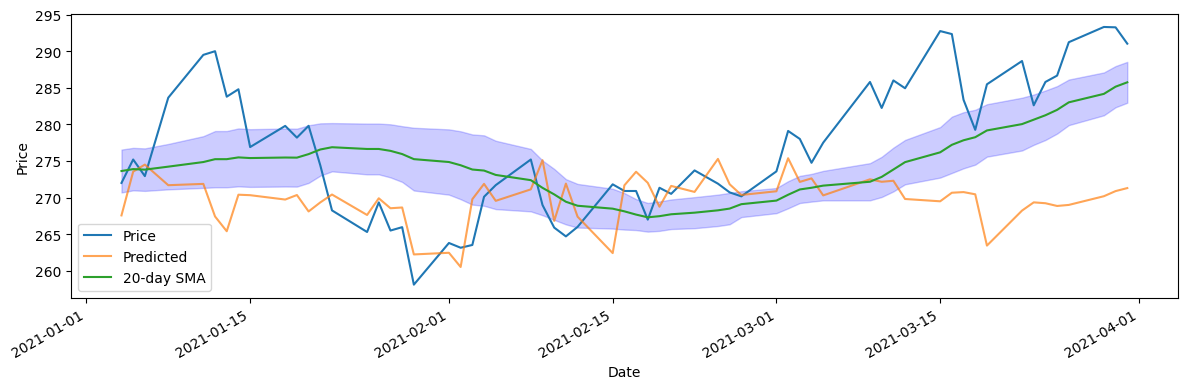

                       Predicted   Price  Difference
Daily Return Total        220.86   88.93      131.93
Weekly Return Total         4.92   12.12       -7.20
Monthly Return Total     -275.07   15.95     -291.02
Total Capital Returns     -49.29  117.00     -166.29
--------------------------------------------------------------------------
Process time series data for Turkey - Koc Holding AS (KCHOL)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 2.764 and an R2 scroe of -1.0361.
          


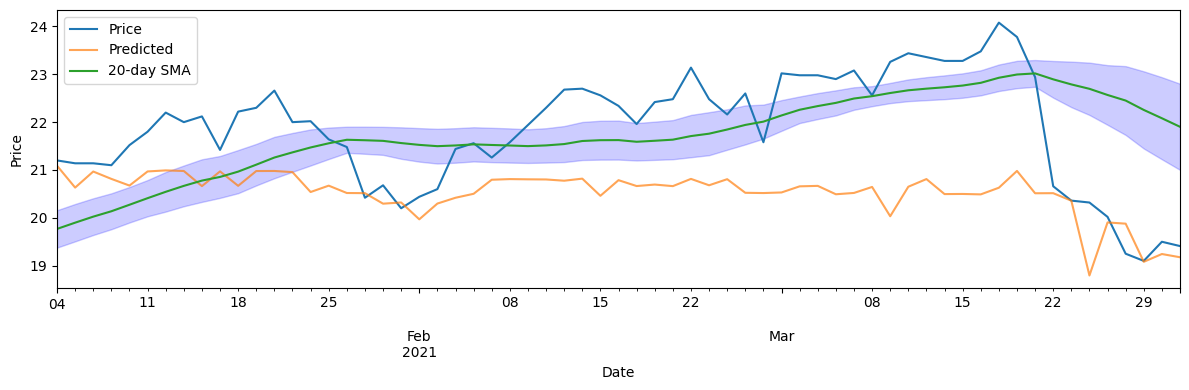

                       Predicted  Price  Difference
Daily Return Total       -125.20   7.94     -133.14
Weekly Return Total       -26.98   0.56      -27.54
Monthly Return Total       -5.26 -16.52       11.26
Total Capital Returns    -157.44  -8.02     -149.42
--------------------------------------------------------------------------
Process time series data for Egypt - Medinet Nasr Housing (MNHD)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 0.0078 and an R2 scroe of 0.3984.
          


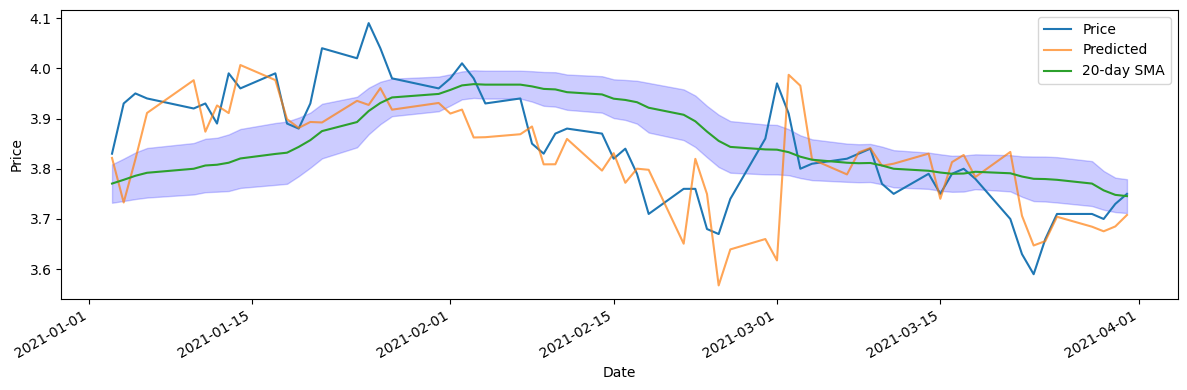

                       Predicted  Price  Difference
Daily Return Total         -1.25   0.18       -1.43
Weekly Return Total        -0.12   0.16       -0.28
Monthly Return Total       -3.83   0.00       -3.83
Total Capital Returns      -5.20   0.34       -5.54
--------------------------------------------------------------------------
Process time series data for Brazil - Minerva SA/Brazil (BEEF3)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 0.1673 and an R2 scroe of -0.891.
          


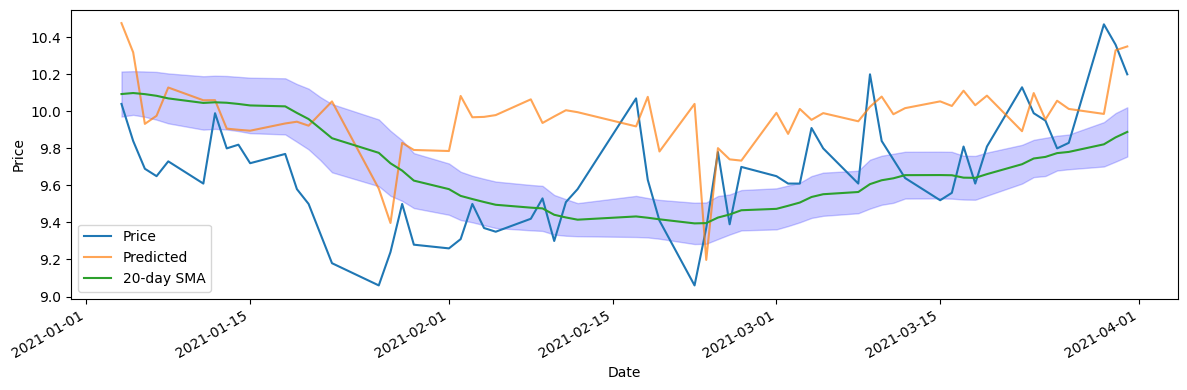

                       Predicted  Price  Difference
Daily Return Total          0.14  12.01      -11.87
Weekly Return Total         0.25   1.39       -1.14
Monthly Return Total        0.00   0.60       -0.60
Total Capital Returns       0.39  14.00      -13.61
--------------------------------------------------------------------------
Process time series data for Argentina - Pampa Energia SA (PAMP)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 48.3317 and an R2 scroe of -2.3181.
          


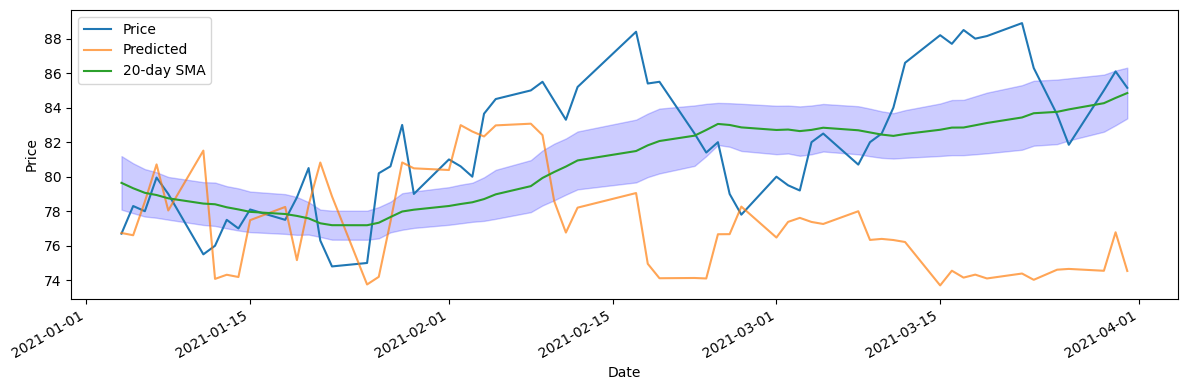

                       Predicted  Price  Difference
Daily Return Total         49.25   81.7      -32.45
Weekly Return Total         3.40   24.8      -21.40
Monthly Return Total      -79.20  -79.2        0.00
Total Capital Returns     -26.55   27.3      -53.85
--------------------------------------------------------------------------
Process time series data for Colombia - Cementos Argos SA (CCB)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 30752.9842 and an R2 scroe of 0.7084.
          


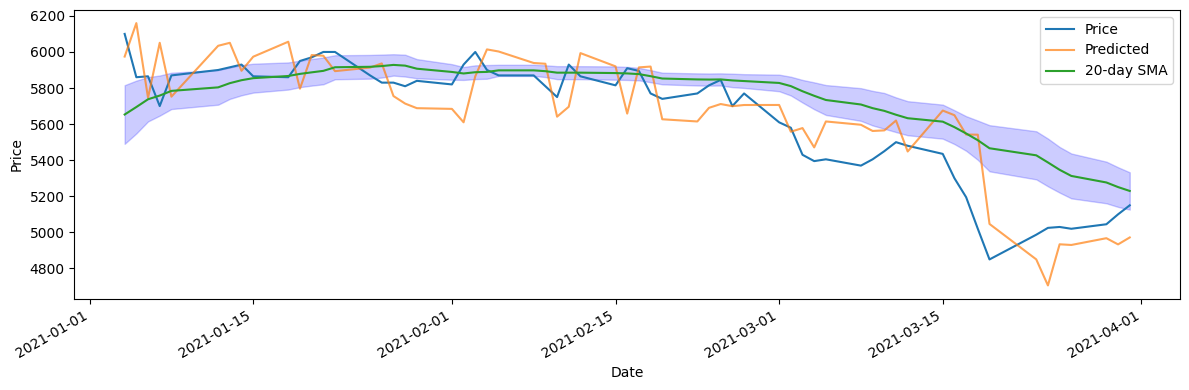

                       Predicted  Price  Difference
Daily Return Total         -5527  -8377        2850
Weekly Return Total        -2905  -1270       -1635
Monthly Return Total       -1210   -430        -780
Total Capital Returns      -9642 -10077         435
--------------------------------------------------------------------------
Process time series data for South Africa - Impala Platinum Holdings Ltd (IMPJ)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 29152071.7527 and an R2 scroe of -2.8106.
          


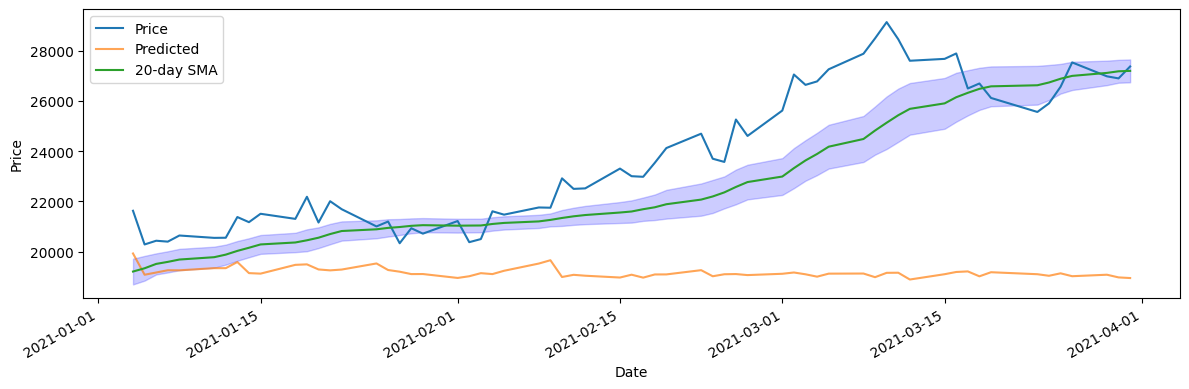

                       Predicted  Price  Difference
Daily Return Total        197249   7938      189311
Weekly Return Total        35297   1336       33961
Monthly Return Total        6958      0        6958
Total Capital Returns     239504   9274      230230
--------------------------------------------------------------------------
Process time series data for South Korea - Dongkuk Steel Mill Co Ltd (001230)...
Make predictions and calculate capital return...
Result:

Best model is XGBRegressor with a mean squared error of 4902393.5112 and an R2 scroe of -1.5496.
          


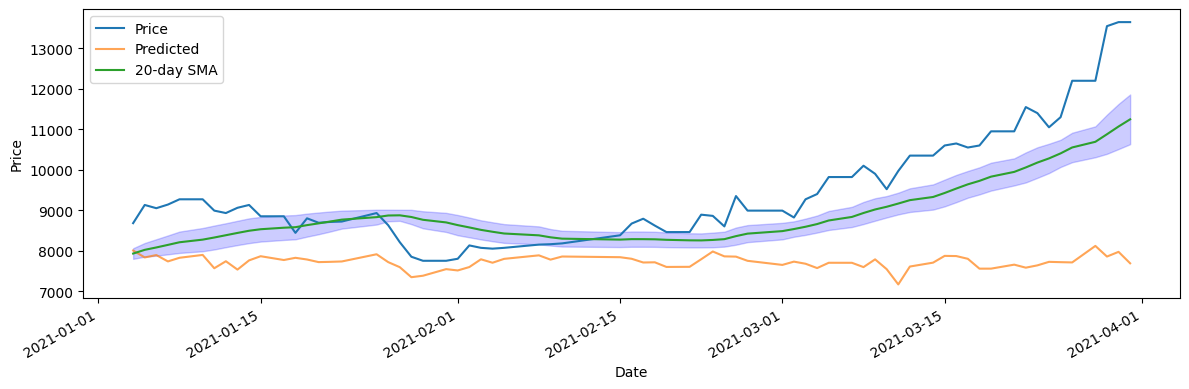

                       Predicted  Price  Difference
Daily Return Total        279610   8220      271390
Weekly Return Total        36540   1890       34650
Monthly Return Total        5900   1500        4400
Total Capital Returns     322050  11610      310440
--------------------------------------------------------------------------


In [59]:
for sheet_name in full_sheet_names:
    df = data_dfs[sheet_name]
    # print(df)
    print(f'Process time series data for {sheet_name}...')
    print('Make predictions and calculate capital return...')
    print('Result:')
    print(process_df(df,
                     bollinger_band_window=20, bollinger_band_std=0.5, plot_bollinger_band=True,
                     normalize_X=True,
                     previous_date_range=[2, 3, 4, 5, 6, 7, 15, 20]))
    print('--------------------------------------------------------------------------')

# The last two stocks have many outliers, which might be the reason why the predictions are not as good as for other stocks.

Distribution of target 'Price' and dependent variables:

Best model is SARIMAX with a mean squared error of 20589321.1067 and an R2 scroe of -1.6913.
          


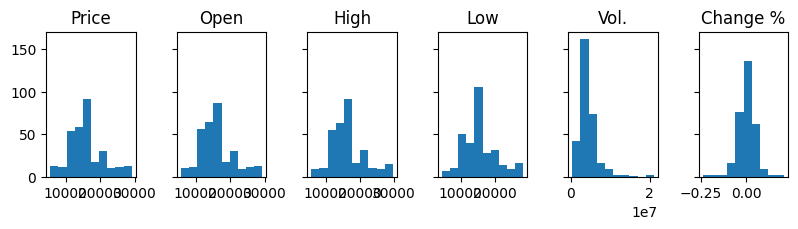

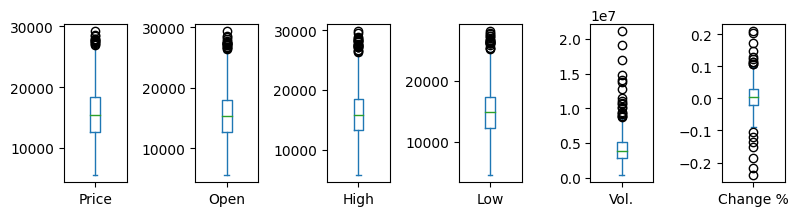

                       Predicted  Price  Difference
Daily Return Total        141357   7938      133419
Weekly Return Total        23357   1336       22021
Monthly Return Total        6958      0        6958
Total Capital Returns     171672   9274      162398


In [ ]:
print(process_df(data_dfs[full_sheet_names[-2]], bollinger_band_std=0.5,
                     plot_histogram=True,
                     plot_bollinger_band=True, smooth_predictions=False))

Distribution of target 'Price' and dependent variables:

Best model is SARIMAX with a mean squared error of 2937738.3215 and an R2 scroe of -0.5278.
          


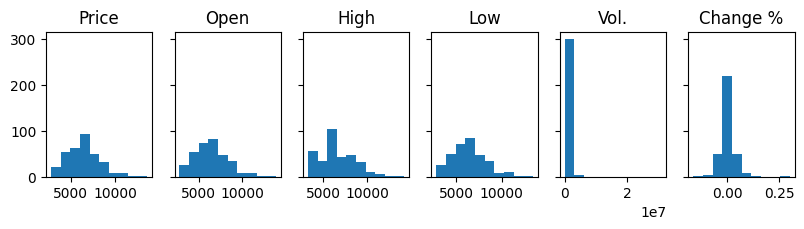

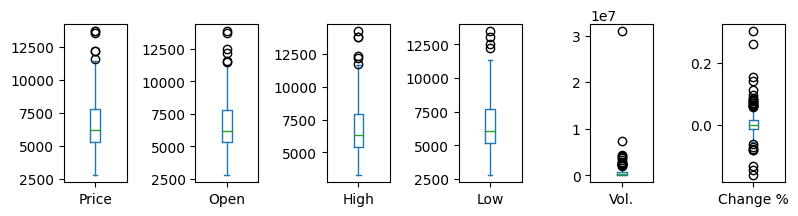

                       Predicted  Price  Difference
Daily Return Total        132140   8220      123920
Weekly Return Total        16850   1890       14960
Monthly Return Total        3700   1500        2200
Total Capital Returns     152690  11610      141080


In [ ]:
print(process_df(data_dfs[full_sheet_names[-1]], bollinger_band_std=0.5,
                     plot_histogram=True,
                     plot_bollinger_band=True, smooth_predictions=False))

In [ ]:
data_dfs_list = list(data_dfs.values())
process_df(data_dfs_list[0], bollinger_band_window=15, bollinger_band_std=0.5, plot_bollinger_band=True,
           previous_date_range=[2, 3, 4, 5, 6, 7])

### <b>5. Train a model</b>

* for nan values, you could consider discarding them if you have enough data.
Or you could plot the data to see how the nan values can be filled (e.g. average, ffill, bfill, etc.). It could be hard to figure this out, so it such cases, could just drop the nan values becausing imputing can bring bias that might not be helpful to the model/predictions.

if the predicted price is lower than the lowerbound =>  buy
if the predicted price is within the Bollinger band => hold
if the predicted price is higher than the upperbound— => sell

1 train a model and predict on a daily, weekly and monthly basis.

2 calculate threshold/uncertainty (of the prediction) (+ bollinger band of the observed data?)<br>
Typical values used:<br>
Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)<br>
Medium term: 20 day moving average, bands at 2 standard deviations.<br>
Long term: 50 day moving average, bands at 2.5 standard deviations.<br>
                                                       
3 decide to buy/hold/sell based on the threshold

4 store the value/profit if I had traded based on the decision. (also need to define how many money/stock I already have.)

SARIMAX is a powerful tool for modeling and forecasting time series data, especially when there are known seasonal patterns and the influence of exogenous variables needs to be considered.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous variables allows for the incorporation of additional factors that may influence the time series.

The SARIMAX model is typically denoted as SARIMAX(p, d, q)(P, D, Q, s), where:

p, d, and q are the orders of the non-seasonal AR, differencing, and MA components, respectively.
P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
Exogenous variables can be included in the model by specifying them separately.

The SARIMAX model assumes that the time series is stationary after differencing. It models the relationship between the observations and the lags of the observations (autoregressive terms), the differences between observations (differencing terms), and the errors (moving average terms), both in the non-seasonal and seasonal components.

p is the number of autoregressive terms
d is the number of non-seasonal differences needed for stationarity
q is the number of lagged forecast errors in the prediction equation

ARIMA. it just takes the past values of the stock market.

=> move on to SARIMA. S stands for seasonality.

=> SARIMAX - also takes into account external features (i.e, other features)
SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with eXogenus factors’

=> primarily they are used for understanding the patterns or features of the time series data but we can use them for predictions.

facebook's PROPHET. easy to understand. conceptually similar to SARIMAX.

Uber's timeseries prediction model.


https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

14:01:51 - cmdstanpy - INFO - Chain [1] start processing
14:01:51 - cmdstanpy - INFO - Chain [1] done processing


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


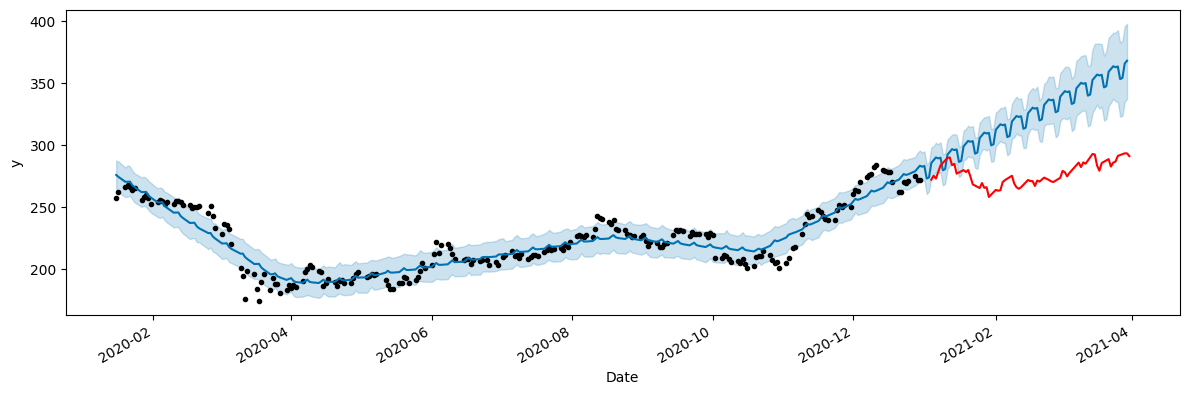

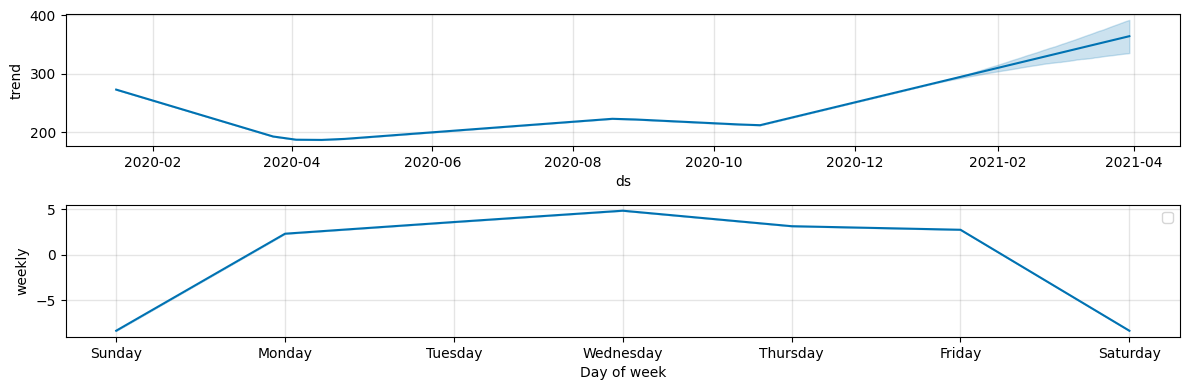

In [ ]:
from prophet import Prophet
m = Prophet()
m.fit(pd.concat([X_train, y_train], axis=1).reset_index().rename(columns={'Date': 'ds', 'Price': 'y'}))

# Forecast for the next 3 months
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
# print(forecast.tail())

m.plot(forecast, figsize=(12, 4))
y_test.plot(label='Price', color='red')
m.plot_components(forecast, figsize=(12, 4))
plt.legend();

3. set evaluation metrics
(e.g., Since stock prices prediction is essentially a regression problem,
 the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %)
 will be our current model evaluation metrics. Both are useful measures of forecast accuracy. )


4. build a prediction model
* When predicting short-term stock prices, it is generally better to focus on more recent data rather than using the data from the entire year. However, it's important to strike a balance between using recent data and having enough historical context. It's recommended to experiment with different time periods and evaluate the performance of your predictions to find the optimal balance.

* LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series.
    It can capture historical trend patterns, and predict future values with high accuracy. 
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571
=> can be difficult/time-consuming to understand. can be tried out after trying simpler models.

* Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects.
On top of that, it adds the X: external variables. If you have any variables that could help your model to improve,
you could add them with SARIMAX.

* exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
es = SimpleExpSmoothing(co2_data.co2.values)
es.fit(smoothing_level=0.01)
plt.plot(co2_data.co2.values)
plt.plot(es.predict(es.params, start=0, end=None))
plt.show()
=> takes in only 1 column

* Reinforcement learning
https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/


5. evaluate model performance
=> create bollinger bands using the prediced price and recommend buy, hold, or sell decisions?


6. based on the final model prediction, recommend BUY, HOLD, SELL decisions for each stock.
(Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.)


7. evaluate on the basis of capital returns (based on the trading decisions).
how to quantify or calculate the returns when we don't know how many stocks we had and when we bought them?


8. use bollinger bands to measure the system/model's effectiveness??

Candlestick charts are used by traders to determine possible price movement based on past patterns. Candlesticks are useful when trading as they show four price points (open, close, high, and low) throughout the period of time the trader specifies.

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Candlestick(
#     x=train_df_1.index,
#     open=train_df_1['Open'],
#     high=train_df_1['High'],
#     low=train_df_1['Low'],
#     close=train_df_1['Close']
#     )
#     ])

# # fig.update_layout(
# #     margin=dict(l=30, r=30, t=10, b=10),
# #     # paper_bgcolor='LightSteelBlue',
# # )

# fig.update_layout(
#     title=f'{stock_name_1}: Daily OHLC', 
#     yaxis_title='Price (USD)',
#     width=900,
#     height=600)

# fig.show()

In [ ]:
# # Candlestick Chart and Volume Separately
# # Source: https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

# from plotly.subplots import make_subplots

# # figure with secondary y-axis
# fig = make_subplots(specs=[[{'secondary_y': True}]])

# # candlestick
# fig.add_trace(
#     go.Candlestick(
#         x=train_df_1.index,
#         open=train_df_1.Open,
#         high=train_df_1.High,
#         low=train_df_1.Low,
#         close=train_df_1.Close,
#         showlegend=False),
#     row=1,
#     col=1,
#     secondary_y=True
# )

# # volume
# fig.add_trace(
#     go.Bar(x=train_df_1.index,
#            y=train_df_1['Vol.'],
#            showlegend=False,
#            marker={
#                'color': 'grey',
#            }),
#     secondary_y=False,
# )

# fig.update_layout(title=f'{stock_name_1}: Daily OHLCV',
#                   yaxis_title='Price (USD)',
#                   width=900,
#                   height=600)

# fig.show()

if the target is short-term decision, 

bullish patterns -> price likely to rise => buy
bearish patterns -> price likely to fall => sell

If a candlestick pattern doesn’t indicate a change in market direction, it is what is known as a continuation pattern. These can help traders to identify a period of rest in the market, when there is market indecision or neutral price movement. => hold

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

From Semih:

Typically bollinger bands are used to make buy and sell decisions if the predicted price is lower than the lowerbound—> buy if the predicted price is higher than the upperbound—> sell

My interpretation is (the way I would approach) we can use bollinger bands to label the data. Afterwards a classifier or a recommendation system could be developed to predict buy and sell decisions. Based on the recommended actions a loss or profit could be calculated. I don’t think there is only one approach but this is how I would approach it.